# Aquaya - Data Analysis Exercise 

dpb, 2024-11-19

- In files: "Data(1).xlsx" (./data/)
- Codebook file: "Codebook (1).xlsx" (./data/)

## Problem Statement & Notes

Please conduct a regression analysis to investigate the relationship between E.coli contamination of a household’s stored drinking water and whether the household received the water quality intervention

Also including the following potential confounders:
- level of education of the household head
- household wealth,
- and whether the household’s water source is improved.


---

Improved water source notes from JMP (link provided in instructions):
```
Note: Improved drinking water sources are those that have the potential to deliver safe water by nature of their design and construction, and include: piped water, boreholes or tubewells, protected dug wells, protected springs, rainwater, and packaged or delivered water
```

- Improved sources:
  - 1, 2, 3, 4 (piped)
  - 5, 6, 8 (borehole/tube/protected)
  - 10 (rainwater)
  - 11, 12, 14, 15 (packaged / delivered)
- Unimproved:
  - 7, 9 (unprotected)
  - 13 (surface)
- Unknown: 96, 99 (other, don't know)

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import statsmodels.api as sm

## Load and explore data

- Load from excel
- Looks like we'll need to do some data treatment
  - 1: moving Level of Ed. (and Gender - not requested in analysis, so will leave for now) from "resp" to "hoh" when respondent is HOH (hoh_yn==1)
  - 2: Indicator variable for Improved vs. unimproved water (see notes above)
  - Some rows are mostly Null / Non-responses - drop these


### Variable notes

`educ` variable is ok and is linearly interpretable *except* for `99` (unknown) value - these will have to be removed or mean-filled. (or median/mode/whatever - just have to replace the '99' value as it breaks linear interpretability).

I don't love the "None" education value being 0, as again, it affects the linearity of the model in a way that isn't consistent with the other levels - will leave for now.

`wealth` variable looks ok and is linearly interpretable (aka on a linear increasing scale, so can be used without adjustment)

`Ecoli_level` is also fine (and linearly interpretable, ascending) so can be used as a continuous dependent variable - though we might also consider using a multinomial logistic regression here (probably not enough data to support); OR we could re-code this as binary "acceptable level" vs. "unacceptable level" and do a normal logit...

Also has several missing values so will result in a smaller data size (~389 samples).

In [2]:
in_file = "./data/Data (1).xlsx"

In [3]:
# df = pd.read_excel(in_file)
df = pd.read_excel(in_file, na_values=["---", " ---", "--- ", " --- "])
df.shape

(489, 17)

In [4]:
df.head(3)

,district,community,resp_gender,hoh_yn,resp_age,resp_educ,hoh_gender,hoh_educ,wealth,DW_source,water_treat_yn,water_treat,stored_water,stored_whencollect,stored_lid,Ecoli_level,intervention_status
0,1,1,2.0,1.0,49.0,3.0,NaN,NaN,2.0,15.0,0,NaN,1.0,7.0,1.0,1.0,0
1,1,1,1.0,1.0,55.0,0.0,NaN,NaN,1.0,2.0,0,NaN,1.0,3.0,1.0,1.0,0
2,1,1,2.0,0.0,67.0,0.0,1.0,3.0,4.0,2.0,0,NaN,0.0,NaN,NaN,NaN,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   district             489 non-null    int64  
 1   community            489 non-null    int64  
 2   resp_gender          469 non-null    float64
 3   hoh_yn               469 non-null    float64
 4   resp_age             469 non-null    float64
 5   resp_educ            469 non-null    float64
 6   hoh_gender           224 non-null    float64
 7   hoh_educ             224 non-null    float64
 8   wealth               469 non-null    float64
 9   DW_source            469 non-null    float64
 10  water_treat_yn       489 non-null    int64  
 11  water_treat          0 non-null      float64
 12  stored_water         469 non-null    float64
 13  stored_whencollect   398 non-null    float64
 14  stored_lid           398 non-null    float64
 15  Ecoli_level          398 non-null    flo

### Fix "educ" variable (& gender while we're at it)

Move approp. values into "hoh_" columns. Replace "99" with NaN, to be dropped later

In [6]:
for t in df.itertuples():
    if t.hoh_yn == 1.0:
        df.at[t.Index, "hoh_gender"] = t.resp_gender
        df.at[t.Index, "hoh_educ"] = t.resp_educ

In [7]:
df["hoh_educ"] = df["hoh_educ"].replace(99.0, np.nan)

In [8]:
df["hoh_educ"].value_counts()

hoh_educ
0.0    154
2.0    153
3.0     67
1.0     54
4.0     21
5.0      8
Name: count, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   district             489 non-null    int64  
 1   community            489 non-null    int64  
 2   resp_gender          469 non-null    float64
 3   hoh_yn               469 non-null    float64
 4   resp_age             469 non-null    float64
 5   resp_educ            469 non-null    float64
 6   hoh_gender           469 non-null    float64
 7   hoh_educ             457 non-null    float64
 8   wealth               469 non-null    float64
 9   DW_source            469 non-null    float64
 10  water_treat_yn       489 non-null    int64  
 11  water_treat          0 non-null      float64
 12  stored_water         469 non-null    float64
 13  stored_whencollect   398 non-null    float64
 14  stored_lid           398 non-null    float64
 15  Ecoli_level          398 non-null    flo

### Add "improved source" indicator

In [16]:
df["improved_source"] = df["DW_source"].isin([1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15]).astype("int32")
df["improved_source"].value_counts()

improved_source
1    408
0     81
Name: count, dtype: int64

### Trim to needed columns only (for simplicity) and Drop NANs

In [17]:
feature_cols = ["intervention_status", "hoh_educ", "wealth", "improved_source"]
outcome_col = "Ecoli_level"

all_cols = feature_cols + [outcome_col]
all_cols

['intervention_status', 'hoh_educ', 'wealth', 'improved_source', 'Ecoli_level']

In [23]:
clean_df = df[all_cols].copy()
clean_df = clean_df.dropna(how="any")
clean_df.shape

(389, 5)

In [24]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 389 entries, 0 to 488
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   intervention_status  389 non-null    int64  
 1   hoh_educ             389 non-null    float64
 2   wealth               389 non-null    float64
 3   improved_source      389 non-null    int32  
 4   Ecoli_level          389 non-null    float64
dtypes: float64(3), int32(1), int64(1)
memory usage: 16.7 KB


## Regression Analysis

Normally I think I'd explore the variable space more before diving in - look at multicolinearity for eg. (explore correlation btw independent variables); maybe do a single regression of treatment to ecoli level (even though a binary indep. variable in a linear model modeling a continuous dep. variable is probably not going to look great).

For now, re: time, I'll just drop all suggested variables of interest into a linear model and see; then consider a multi-logistic regression.

Using `statsmodels`, a well-respected and mature python package for traditional stats

**Also** notable that I'm **not** doing selections, leave outs, or cross-validation, meaning I'm just doing the analysis on given sample and making no statement whatsoever about how this model (or the relationship it shows) generalizes to data outside this sample.

In [25]:
X = clean_df[feature_cols].copy()
X = sm.add_constant(X)
y = clean_df[outcome_col]

X.shape, y.shape

((389, 5), (389,))

In [27]:
linr = sm.OLS(y, X)
res = linr.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            Ecoli_level   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     26.90
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           1.09e-19
Time:                        18:56:25   Log-Likelihood:                -433.60
No. Observations:                 389   AIC:                             877.2
Df Residuals:                     384   BIC:                             897.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.6947    

## Results

Ok, a bit surprising - what I'm seeing here is that only "improved source" has a P-value worth considering in terms of relationship to Ecoli levels in this data sample; relatively strong negative coeff interpreted as "if source is improved (val=1), it drives ecoli level down (lower values ie lower risk).

HOH Education level, Wealth, and *especially* Intervention Status have a P-value indicating little interpretable relationship to Ecoli levels. (Wealth may be the next closest).

A simple check: plotting all variables in relation to ecoli levels, just to qualitatively visually investigate (below)

- Intervention status really does not look indicative of E Coli levels (similar Ecoli resulst, potentially even worse, for intervention samples)
- No individual plot looks particularly compelling, even "improved source" - no easy eyeball test here.

## If I had more time (thoughts)

I'd re-code the outcome to binary (acceptable vs. unacceptable) and try with logistic regression; I think the sample is probably too small to get any traction out of a multinomial regression with four possible outcomes.

In [ ]:
feature_cols = ["intervention_status", "hoh_educ", "wealth", "improved_source"]
outcome_col = "Ecoli_level"

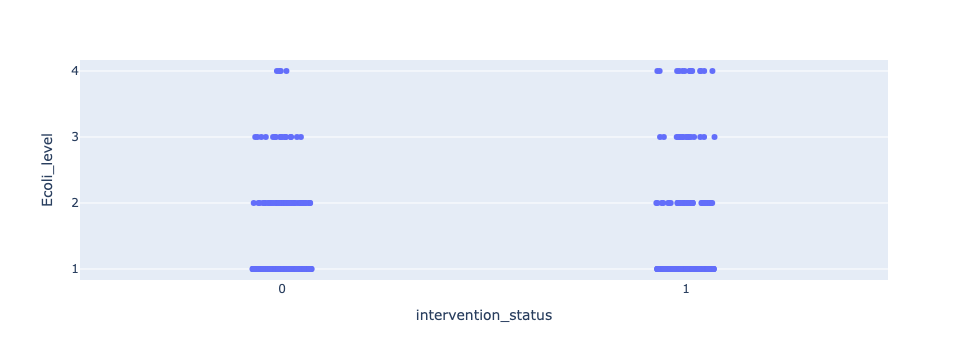

In [29]:
px.strip(df, x="intervention_status", y="Ecoli_level")

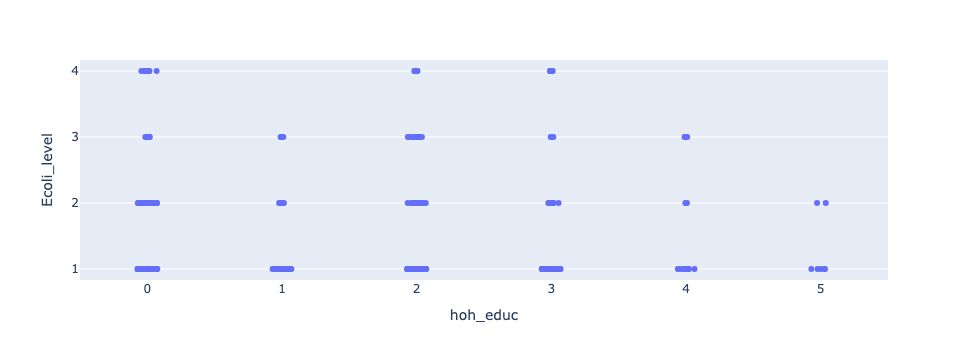

In [30]:
px.strip(df, x="hoh_educ", y="Ecoli_level")

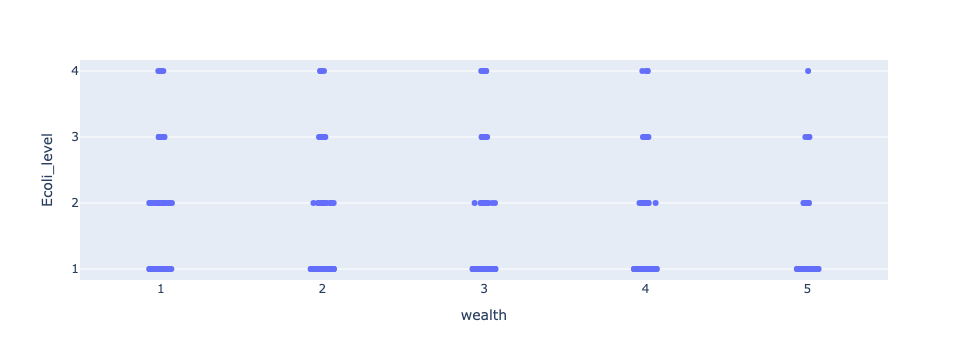

In [31]:
px.strip(df, x="wealth", y="Ecoli_level")

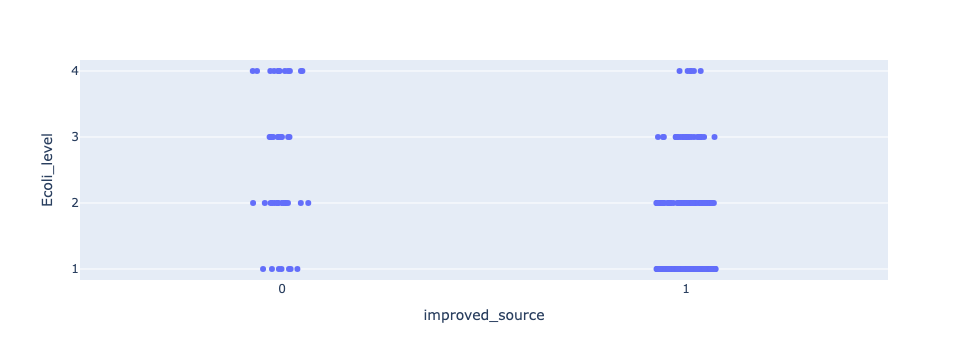

In [32]:
px.strip(df, x="improved_source", y="Ecoli_level")